In [4]:
from qiskit import __version__
print(__version__)

1.4.2


In [5]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector, state_fidelity, Pauli, DensityMatrix
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit import transpile 
import numpy as np
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError, pauli_error 
from qiskit.circuit.library import HGate, UnitaryGate, CXGate
import matplotlib.pyplot as plt

In [6]:
from steane_ec_decoder import bool_syndrome_flag, syndrome

# Encoding Circuit

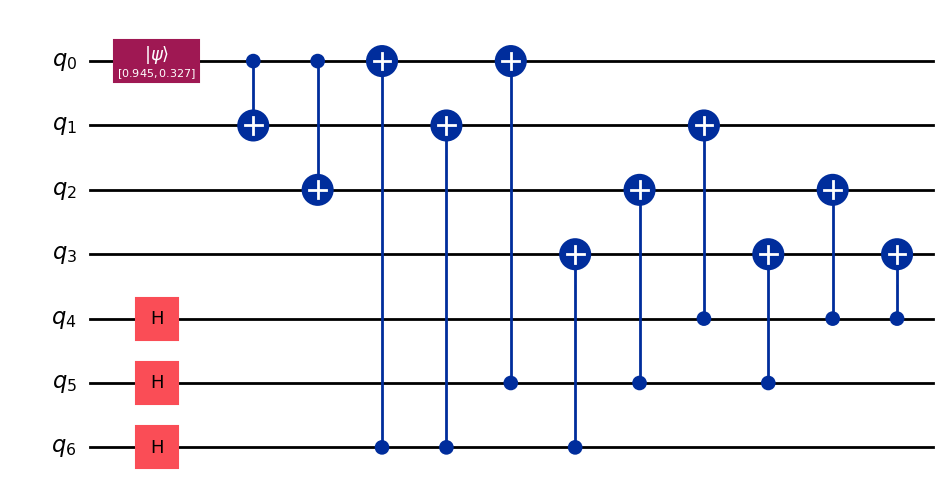

In [7]:
encoding = QuantumCircuit(7)

theta = np.arctan(np.sqrt((np.sqrt(5) - 1) / 2))
amp_0 = np.cos(theta/2)
amp_1 = np.sin(theta/2)

encoding.initialize([amp_0, amp_1], 0)

for i in range(4, 7):
    encoding.h(i)

encoding.cx(0, 1)
encoding.cx(0, 2)
encoding.cx(6, 0)
encoding.cx(6, 1)
encoding.cx(6, 3)
encoding.cx(5, 0)
encoding.cx(5, 2)
encoding.cx(5, 3)
encoding.cx(4, 1)
encoding.cx(4, 2)
encoding.cx(4, 3)

display(encoding.draw(output='mpl'))

# Syndrome Extraction Circuit without Flag

In [8]:
se_nf = QuantumCircuit(23, 16)
# First 7 qubits are data qubits in the logical |\psi> state
# Next 8 are prepared in the logical |+> state
# Last 8 are prepared in the logical |0> state

# Encoding first 7 qubits, 0-6
theta = np.arctan(np.sqrt((np.sqrt(5) - 1) / 2))
amp_0 = np.cos(theta/2)
amp_1 = np.sin(theta/2)

se_nf.initialize([amp_0, amp_1], 0)
for i in range(4, 7):
    se_nf.h(i)
se_nf.cx(0, 1)
se_nf.cx(0, 2)
se_nf.cx(6, 0)
se_nf.cx(6, 1)
se_nf.cx(6, 3)
se_nf.cx(5, 0)
se_nf.cx(5, 2)
se_nf.cx(5, 3)
se_nf.cx(4, 1)
se_nf.cx(4, 2)
se_nf.cx(4, 3)
se_nf.barrier()

# Encoding next 8 qubits, 7-14
se_nf.h(7)
se_nf.h(8)
se_nf.h(10)
se_nf.cx(7, 11)
se_nf.cx(8, 9)
se_nf.cx(10, 12)
se_nf.cx(7, 13)
se_nf.cx(10, 11)
se_nf.cx(8, 12)
se_nf.cx(7, 9)
se_nf.cx(12, 13)
se_nf.cx(11, 14)
se_nf.cx(9, 14)
se_nf.cx(12, 14)
se_nf.measure([14], [0]) # Post-select for 0
for i in range(7, 14):
    se_nf.h(i)
se_nf.barrier()

# Encoding last 8 qubits, 15-22
se_nf.h(15)
se_nf.h(16)
se_nf.h(18)
se_nf.cx(15, 19)
se_nf.cx(16, 17)
se_nf.cx(18, 20)
se_nf.cx(15, 21)
se_nf.cx(18, 19)
se_nf.cx(16, 20)
se_nf.cx(15, 17)
se_nf.cx(20, 21)
se_nf.cx(19, 22)
se_nf.cx(17, 22)
se_nf.cx(20, 22)
se_nf.measure([22], [1]) # Post-select for 0
se_nf.barrier()
    
# Transversal CNOTs from data qubits to next 7 qubits and measure syndrome
for i in range(7):
    se_nf.cx(i, i+7)
for i in range(7):
    se_nf.measure([i+7], [i+2])
se_nf.barrier()

# Transversal CNOTs from last 7 qubits to data qubits and measure syndrome
for i in range(7):
    se_nf.cx(i+15, i)
for i in range(15, 22):
    se_nf.h(i)
for i in range(7):
    se_nf.measure([i+15], [i+9])
    
#display(se_nf.draw("mpl"))

# Syndrome Extraction Circuit with Flag

In [9]:
se_wf = QuantumCircuit(13, 6)
# First 7 qubits are encoding in the logical |psi> state
# Next 6 qubits are ancillas

# Encoding first 7 qubits, 0-6
theta = np.arctan(np.sqrt((np.sqrt(5) - 1) / 2))
amp_0 = np.cos(theta/2)
amp_1 = np.sin(theta/2)

se_wf.initialize([amp_0, amp_1], 0)
for i in range(4, 7):
    se_wf.h(i)
se_wf.cx(0, 1)
se_wf.cx(0, 2)
se_wf.cx(6, 0)
se_wf.cx(6, 1)
se_wf.cx(6, 3)
se_wf.cx(5, 0)
se_wf.cx(5, 2)
se_wf.cx(5, 3)
se_wf.cx(4, 1)
se_wf.cx(4, 2)
se_wf.cx(4, 3)
se_wf.barrier()

# Encoding next 6 qubits and applying CNOTs and measurements, 7-12
se_wf.h(7)
se_wf.h(11)
se_wf.h(12)
se_wf.cx(7, 4)
se_wf.cx(6, 8)
se_wf.cx(5, 9)
se_wf.cx(7, 9)
se_wf.cx(7, 0)
se_wf.cx(4, 8)
se_wf.cx(1, 9)
se_wf.cx(7, 2)
se_wf.cx(3, 8)
se_wf.cx(6, 9)
se_wf.cx(7, 8)
se_wf.cx(7, 6)
se_wf.cx(5, 8)
se_wf.cx(2, 9)
se_wf.cx(4, 10)
se_wf.cx(11, 6)
se_wf.cx(12, 5)
se_wf.cx(12, 10)
se_wf.cx(0, 10)
se_wf.cx(11, 4)
se_wf.cx(12, 1)
se_wf.cx(2, 10)
se_wf.cx(11, 3)
se_wf.cx(12, 6)
se_wf.cx(11, 10)
se_wf.cx(6, 10)
se_wf.cx(11, 5)
se_wf.cx(12, 2)

se_wf.h(7)
se_wf.h(11)
se_wf.h(12)
for i in range(6):
    se_wf.measure([i+7], [i])
    
#display(se_wf.draw('mpl'))

# Logical Error Rate for Encoding Circuit

In [10]:
logical_error_circ = QuantumCircuit(29, 22)
# First 7 qubits are data qubits
# Next 6 qubits are for syndrome extraction with flag
# Next 16 qubits are for syndrome extractino without flag

logical_error_circ.initialize([amp_0, amp_1], 0)

for i in range(7):
    logical_error_circ.id(i)

for i in range(4, 7):
    logical_error_circ.h(i)

logical_error_circ.cx(0, 1)
logical_error_circ.cx(0, 2)
logical_error_circ.cx(6, 0)
logical_error_circ.cx(6, 1)
logical_error_circ.cx(6, 3)
logical_error_circ.cx(5, 0)
logical_error_circ.cx(5, 2)
logical_error_circ.cx(5, 3)
logical_error_circ.cx(4, 1)
logical_error_circ.cx(4, 2)
logical_error_circ.cx(4, 3)

In [11]:
noise_model = NoiseModel()

noise_model.add_all_qubit_quantum_error(depolarizing_error(0.005,1), ['id'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.005,1), ['h'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.05,2), ['cx'])

# 5% chance of flipping 0 <-> 1
readout_err = ReadoutError([[0.995, 0.005],  # P(measured 0 | actual 0), P(1 | 0)
                            [0.005, 0.995]]) # P(0 | 1), P(1 | 1)

# Apply to all qubits being measured
noise_model.add_readout_error(readout_err, [7])
noise_model.add_readout_error(readout_err, [8])


meas_circuit_noise = logical_error_circ.copy()
meas_circuit_noise.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=29, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(29, 'q'), 0), Qubit(QuantumRegister(29, 'q'), 1), Qubit(QuantumRegister(29, 'q'), 2), Qubit(QuantumRegister(29, 'q'), 3), Qubit(QuantumRegister(29, 'q'), 4), Qubit(QuantumRegister(29, 'q'), 5), Qubit(QuantumRegister(29, 'q'), 6), Qubit(QuantumRegister(29, 'q'), 7), Qubit(QuantumRegister(29, 'q'), 8), Qubit(QuantumRegister(29, 'q'), 9), Qubit(QuantumRegister(29, 'q'), 10), Qubit(QuantumRegister(29, 'q'), 11), Qubit(QuantumRegister(29, 'q'), 12), Qubit(QuantumRegister(29, 'q'), 13), Qubit(QuantumRegister(29, 'q'), 14), Qubit(QuantumRegister(29, 'q'), 15), Qubit(QuantumRegister(29, 'q'), 16), Qubit(QuantumRegister(29, 'q'), 17), Qubit(QuantumRegister(29, 'q'), 18), Qubit(QuantumRegister(29, 'q'), 19), Qubit(QuantumRegister(29, 'q'), 20), Qubit(QuantumRegister(29, 'q'), 21), Qubit(QuantumRegister(29, 'q'), 22), Qubit(QuantumRegister(29, 'q'), 23), Qubit(QuantumReg

In [12]:
# Syndrome measurement using flag

# Encoding next 6 qubits and applying CNOTs and measurements, 7-12
meas_circuit_noise.h(7)
meas_circuit_noise.h(11)
meas_circuit_noise.h(12)
meas_circuit_noise.cx(7, 4)
meas_circuit_noise.cx(6, 8)
meas_circuit_noise.cx(5, 9)
meas_circuit_noise.cx(7, 9)
meas_circuit_noise.cx(7, 0)
meas_circuit_noise.cx(4, 8)
meas_circuit_noise.cx(1, 9)
meas_circuit_noise.cx(7, 2)
meas_circuit_noise.cx(3, 8)
meas_circuit_noise.cx(6, 9)
meas_circuit_noise.cx(7, 8)
meas_circuit_noise.cx(7, 6)
meas_circuit_noise.cx(5, 8)
meas_circuit_noise.cx(2, 9)
meas_circuit_noise.cx(4, 10)
meas_circuit_noise.cx(11, 6)
meas_circuit_noise.cx(12, 5)
meas_circuit_noise.cx(12, 10)
meas_circuit_noise.cx(0, 10)
meas_circuit_noise.cx(11, 4)
meas_circuit_noise.cx(12, 1)
meas_circuit_noise.cx(2, 10)
meas_circuit_noise.cx(11, 3)
meas_circuit_noise.cx(12, 6)
meas_circuit_noise.cx(11, 10)
meas_circuit_noise.cx(6, 10)
meas_circuit_noise.cx(11, 5)
meas_circuit_noise.cx(12, 2)

meas_circuit_noise.h(7)
meas_circuit_noise.h(11)
meas_circuit_noise.h(12)
for i in range(6):
    meas_circuit_noise.measure([i+7], [i])
    
#############################################

# Encoding next 8 qubits, 13-20
meas_circuit_noise.h(13)
meas_circuit_noise.h(14)
meas_circuit_noise.h(16)
meas_circuit_noise.cx(13, 17)
meas_circuit_noise.cx(14, 15)
meas_circuit_noise.cx(16, 18)
meas_circuit_noise.cx(13, 19)
meas_circuit_noise.cx(16, 17)
meas_circuit_noise.cx(14, 18)
meas_circuit_noise.cx(13, 15)
meas_circuit_noise.cx(18, 19)
meas_circuit_noise.cx(17, 20)
meas_circuit_noise.cx(15, 20)
meas_circuit_noise.cx(18, 20)
meas_circuit_noise.measure([20], [6]) # Post-select for 0
for i in range(13, 20):
    meas_circuit_noise.h(i)
meas_circuit_noise.barrier()

# Encoding last 8 qubits, 21-28
meas_circuit_noise.h(21)
meas_circuit_noise.h(22)
meas_circuit_noise.h(24)
meas_circuit_noise.cx(21, 25)
meas_circuit_noise.cx(22, 23)
meas_circuit_noise.cx(24, 26)
meas_circuit_noise.cx(21, 27)
meas_circuit_noise.cx(24, 25)
meas_circuit_noise.cx(22, 26)
meas_circuit_noise.cx(21, 23)
meas_circuit_noise.cx(26, 27)
meas_circuit_noise.cx(25, 28)
meas_circuit_noise.cx(23, 28)
meas_circuit_noise.cx(26, 28)
meas_circuit_noise.measure([28], [7]) # Post-select for 0
meas_circuit_noise.barrier()
    
# Transversal CNOTs from data qubits to next 7 qubits and measure syndrome
for i in range(7):
    meas_circuit_noise.cx(i, i+13)
for i in range(7):
    meas_circuit_noise.measure([i+13], [i+8])
meas_circuit_noise.barrier()

# Transversal CNOTs from last 7 qubits to data qubits and measure syndrome
for i in range(7):
    meas_circuit_noise.cx(i+21, i)
for i in range(21, 28):
    meas_circuit_noise.h(i)
for i in range(7):
    meas_circuit_noise.measure([i+21], [i+15])

backend = AerSimulator(noise_model=noise_model, method='matrix_product_state')
transpiled = transpile(meas_circuit_noise, backend, optimization_level=0)
job = backend.run(transpiled, shots=1, memory=True)
result = job.result()

# Extracting the syndromes
memory = result.get_memory()[0]
flag_syndrome = memory[-6:]
flag_syndrome = flag_syndrome[::-1]
flag_syndrome = [int (b) for b in flag_syndrome]

indices_z = [3, 1, 2]
syndrome_flag_z = [flag_syndrome[i] for i in indices_z]

indices_x = [0, 4, 5]
syndrome_flag_x = [flag_syndrome[i] for i in indices_x]

0000100010010100001100
[0, 0, 1, 1, 0, 0]
[1, 0, 1]
[0, 0, 0]


In [24]:
print(memory)
print(flag_syndrome)
for i in range(3):
    if (syndrome_flag_z[i] == 0):
        syndrome_flag_z[i] = 1
    elif (syndrome_flag_z[i] == 1):
        syndrome_flag_z[i] = -1
    
    if (syndrome_flag_x[i] == 0):
        syndrome_flag_x[i] = 1
    elif (syndrome_flag_x[i] == 1):
        syndrome_flag_x[i] = -1
print(syndrome_flag_z)
print(syndrome_flag_x)

0000100010010100001100
[0, 0, 1, 1, 0, 0]
[-1, 1, -1]
[1, 1, 1]


In [18]:
postselect1 = memory[-7]
postselect2 = memory[-8]
print(postselect1)
print(postselect2)

0
0


In [25]:
no_flag_allqubits_z = memory[-15:-8]
no_flag_allqubits_z = no_flag_allqubits_z[::-1]
no_flag_allqubits_z = [int (b) for b in no_flag_allqubits_z]

no_flag_allqubits_x = memory[-22:-15]
no_flag_allqubits_x = no_flag_allqubits_x[::-1]
no_flag_allqubits_x = [int (b) for b in no_flag_allqubits_x]


for i in range(7):
    if (no_flag_allqubits_z[i] == 0):
        no_flag_allqubits_z[i] = 1
    elif (no_flag_allqubits_z[i] == 1):
        no_flag_allqubits_z[i] = -1
        
    if (no_flag_allqubits_x[i] == 0):
        no_flag_allqubits_x[i] = 1
    elif (no_flag_allqubits_x[i] == 1):
        no_flag_allqubits_x[i] = -1

print(no_flag_allqubits_z)
print(no_flag_allqubits_x)

[-1, 1, -1, 1, 1, -1, 1]
[1, 1, -1, 1, 1, 1, 1]


In [26]:
parity1_z = 1
for i in [0, 2, 4, 6]:
    parity1_z *= no_flag_allqubits_z[i]

parity2_z = 1
for i in [3, 4, 5, 6]:
    parity2_z *= no_flag_allqubits_z[i]
    
parity3_z = 1
for i in [1, 2, 5, 6]:
    parity3_z *= no_flag_allqubits_z[i]
    
parity1_x = 1
for i in [0, 2, 4, 6]:
    parity1_x *= no_flag_allqubits_x[i]

parity2_x = 1
for i in [3, 4, 5, 6]:
    parity2_x *= no_flag_allqubits_x[i]
    
parity3_x = 1
for i in [1, 2, 5, 6]:
    parity3_x *= no_flag_allqubits_x[i]
    
syndrome_no_flag_z = [parity1_z, parity2_z, parity3_z]
syndrome_no_flag_x = [parity1_x, parity2_x, parity3_x]
print(syndrome_no_flag_z)
print(syndrome_no_flag_x)

[1, -1, 1]
[-1, 1, -1]


In [28]:
print(bool_syndrome_flag(syndrome_flag_z, syndrome_flag_x))
print(syndrome(syndrome_flag_z, syndrome_flag_x, syndrome_no_flag_z, syndrome_no_flag_x))

False
('IIXIIIX', 'IIZIIII')
